In [1]:
# !pip install wordcloud
!pip install emoji
# !pip install xgboost
!pip install ekphrasis -U
# !pip install gensim
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 906.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer


import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score


#from sklearn.feature_extraction.review import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import emoji
import regex as re

import json
import pandas as pd
import glob
import spacy
import nltk

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from transformers import BertTokenizer, BertModel
import torch
import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

/Users/mayyaspirina/Documents/HSE/HSE3/Nlp/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Download dataset

First off, we downloaded tweet topic classification dataset from huggingface.co and removed duplicating texts.

In [3]:
!git clone https://huggingface.co/datasets/cardiffnlp/tweet_topic_single

Cloning into 'tweet_topic_single'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 142 (delta 81), reused 142 (delta 81), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 1.36 MiB | 3.25 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [4]:
texts = []
dates = []
labels = []
ids = []
label_names = []

files = glob.glob('tweet_topic_single/dataset/*/*.json')

for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tweet = json.loads(line)
        texts.append(tweet['text'])
        labels.append(tweet['label'])
        label_names.append(tweet['label_name'])

tweets_df = pd.DataFrame({"texts": texts, "labels": labels, "label_names": label_names})
data = tweets_df
data.head()

,texts,labels,label_names
0,Jalen hurts first drive low key lookin really ...,4,sports_&_gaming
1,Sometimes The Bad Things That Happen In Our Li...,3,daily_life
2,I request all the country men to give holiday...,3,daily_life
3,Quicker end than expected. Had a blast {@USA S...,4,sports_&_gaming
4,The first #musicofthefuturevideooftheweek is n...,2,pop_culture


In [5]:
data.drop_duplicates(subset='texts', inplace=True)
data

,texts,labels,label_names
0,Jalen hurts first drive low key lookin really ...,4,sports_&_gaming
1,Sometimes The Bad Things That Happen In Our Li...,3,daily_life
2,I request all the country men to give holiday...,3,daily_life
3,Quicker end than expected. Had a blast {@USA S...,4,sports_&_gaming
4,The first #musicofthefuturevideooftheweek is n...,2,pop_culture
...,...,...,...
6992,Did we learn more about the {@Buffalo Bills@} ...,4,sports_&_gaming
6993,#IntroduceYourDad TRUE STORY All of my younge...,3,daily_life
6994,I’m so confused about the piece I just watched...,2,pop_culture
6995,A Special Place In Hell by Reid Henry {{URL}} ...,2,pop_culture


# EDA

Overall, we have 6996 texts in the dataset with `sports_&_gaming`, `daily_life`, `pop_culture` being dominating topics. \
At the same time `arts_&_culture`, `science_&_technology` and `business_&_entrepreneurs` have less than 500 tweets.

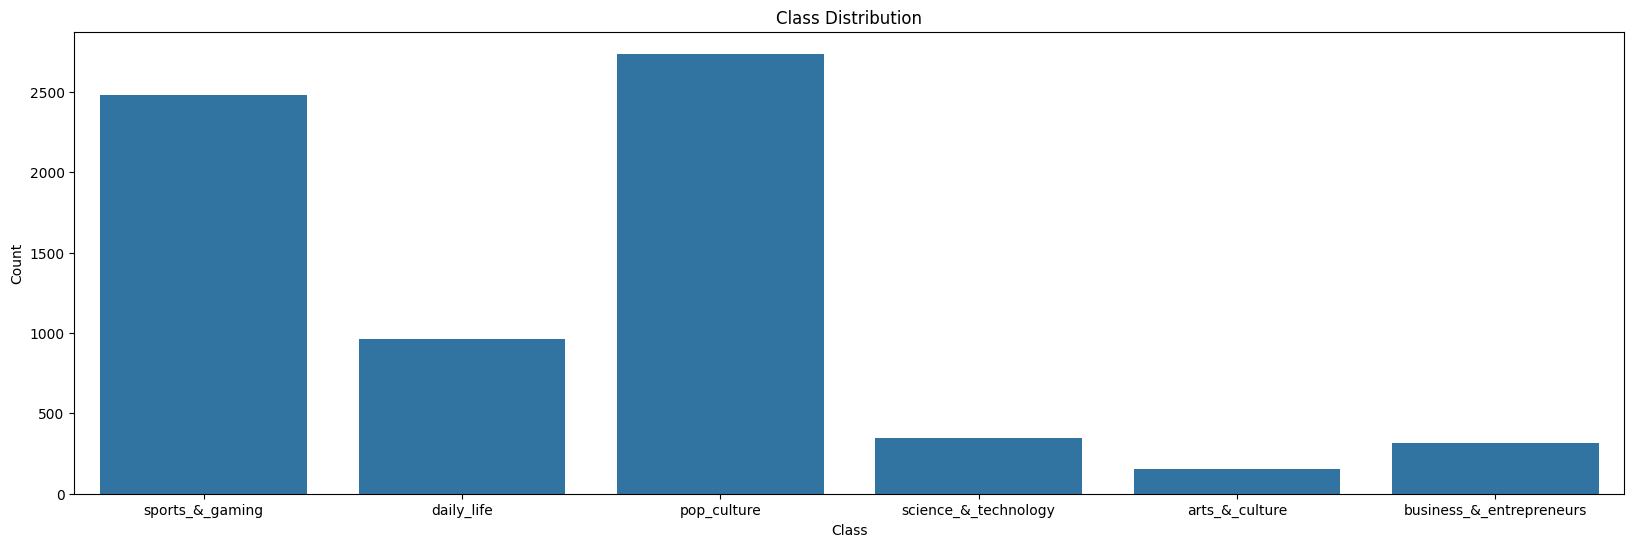

In [6]:
# Class distribution
plt.figure(figsize=(20,6))
sns.countplot(data=data, x='label_names')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Length of tweets cannot help us to idntify the topic, for most tweets it is from 50 to 300 words. Only for the greatest topics in size, prevalence of shorter texts is notable.

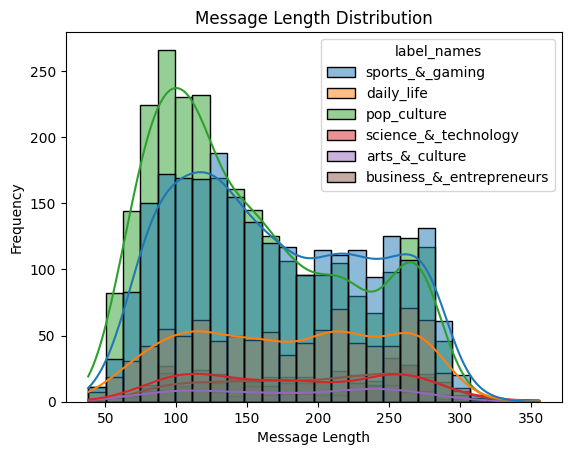

In [7]:
# Message Length Distribution according to the target value
data['text_length'] = data['texts'].apply(len)
sns.histplot(data=data, x='text_length', hue='label_names', kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

Word clouds show that URL and USERNAME meet often, however, they are not helpful for analysis. They represent links and usernames, but we have no knowledge about their relationship to the topic. Also, inside each word cloud some words appear several times, thus, some preprocessing is needed.

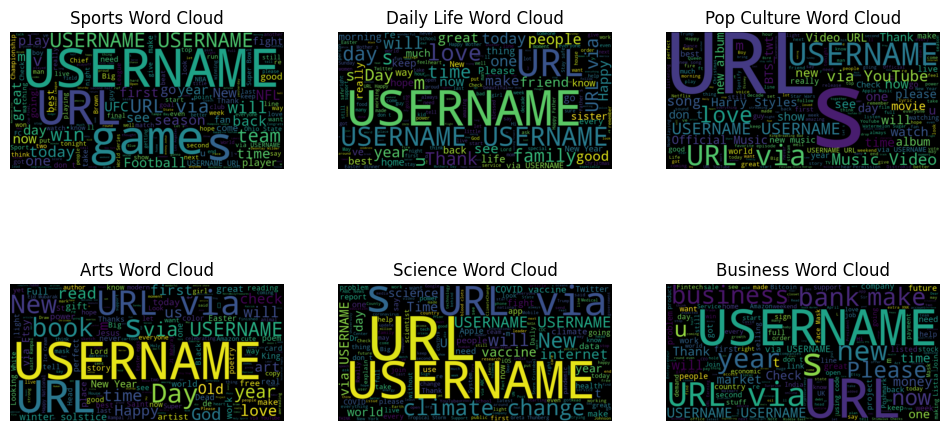

In [8]:
# WordClouds for targets
sports = ' '.join(data[data['label_names'] == 'sports_&_gaming']['texts'])
daily = ' '.join(data[data['label_names'] == 'daily_life']['texts'])
pop_culture = ' '.join(data[data['label_names'] == 'pop_culture']['texts'])
arts = ' '.join(data[data['label_names'] == 'arts_&_culture']['texts'])
science = ' '.join(data[data['label_names'] == 'science_&_technology']['texts'])
business = ' '.join(data[data['label_names'] == 'business_&_entrepreneurs']['texts'])

sports_wordcloud = WordCloud(width=800, height=400).generate(sports)
daily_wordcloud = WordCloud(width=800, height=400).generate(daily)
pop_culture_wordcloud = WordCloud(width=800, height=400).generate(pop_culture)
arts_wordcloud = WordCloud(width=800, height=400).generate(arts)
science_wordcloud = WordCloud(width=800, height=400).generate(science)
business_wordcloud = WordCloud(width=800, height=400).generate(business)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(sports_wordcloud, interpolation='bilinear')
plt.title('Sports Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(daily_wordcloud, interpolation='bilinear')
plt.title('Daily Life Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pop_culture_wordcloud, interpolation='bilinear')
plt.title('Pop Culture Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(arts_wordcloud, interpolation='bilinear')
plt.title('Arts Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(science_wordcloud, interpolation='bilinear')
plt.title('Science Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(business_wordcloud, interpolation='bilinear')
plt.title('Business Word Cloud')
plt.axis('off')

plt.show()

# Data Preprocessing

The following function allows to:
1) Change all capital letters to lowercase letters
2) Repalce common categories like phone, email by respective words
3) Split hashtags into several words
4) Correct spelling mistakes

In [9]:
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

def prep(text):
    return " ".join(text_processor.pre_process_doc(text))

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [10]:
data['texts'] = data['texts'].apply(prep)

## Lemmatization
Lemmatization was used to reduce word to its root form

In [11]:
def lemmatization(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)
    return " ".join([token.lemma_ for token in doc])

In [12]:
nlp = spacy.load('en_core_web_sm')

In [13]:
data['texts'] = data['texts'].apply(lemmatization)

In [14]:
data

,texts,labels,label_names,text_length
0,jalen hurt first drive low key lookin really g...,4,sports_&_gaming,99
1,sometimes the bad thing that happen in our lif...,3,daily_life,163
2,I request all the country man to give holiday ...,3,daily_life,241
3,quick end than expect . have a blast { < user ...,4,sports_&_gaming,125
4,the first music of the future video of the wee...,2,pop_culture,210
...,...,...,...,...
6992,do we learn more about the { < user > bill @ }...,4,sports_&_gaming,298
6993,introduce your dad true story all of my young ...,3,daily_life,161
6994,I ' m so confused about the piece I just watch...,2,pop_culture,215
6995,a special place in hell by reid henry { { url ...,2,pop_culture,155


## Removing stop words

In [15]:
def stop_words(texts):
    stop_words = set(stopwords.words('english'))
    regex = re.compile('[^a-zA-Z]')
    preprocess_texts = []
    for text in tqdm(texts):
        text = text.lower()
        text = regex.sub(' ', text)
        word_tokens = nltk.word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if (w not in stop_words) & (w != 'url')  & (w != 'username') & (w != 'via')
                             & (w != 'ha') & (w != 'user')  & (w != 'number')& (w != 'love') & (w != 'time')]

        processed = []
        for word in filtered_sentence:
            word = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', word)
            word = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress', word)
            word = re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', word)
            processed.append(word)

        preprocess_texts.append(' '.join(processed))

    return preprocess_texts

In [16]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayyaspirina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayyaspirina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
data['texts'] = stop_words(data['texts'])
data['texts']

100%|████████████████████████████████████████████████████████████████████████████████████| 6996/6996 [00:01<00:00, 5686.56it/s]


0       jalen hurt first drive low key lookin really g...
1       sometimes bad thing happen life put directly g...
2       request country man give holiday servant work ...
3       quick end expect blast softball girl coach tea...
4       first music future video week live feature wat...
                              ...                        
6992    learn bill england patriot yesterday patriot a...
6993    introduce dad true story young cousin side als...
6994    confused piece watch sunday morning erin moria...
6995    special place hell reid henry play check amazi...
6996    idk man respect artist human one hardworking p...
Name: texts, Length: 6996, dtype: object

Now word clouds are representable with relevant most common words.

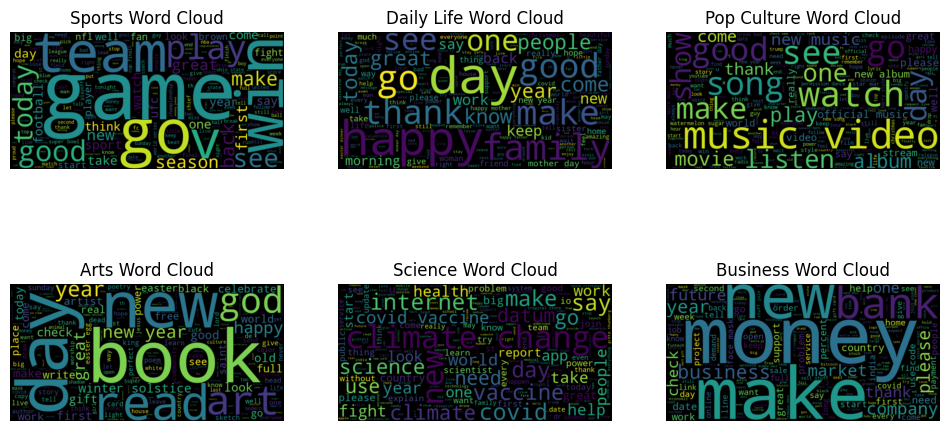

In [18]:
# WordClouds after preprocessing
sports = ' '.join(data[data['label_names'] == 'sports_&_gaming']['texts'])
daily = ' '.join(data[data['label_names'] == 'daily_life']['texts'])
pop_culture = ' '.join(data[data['label_names'] == 'pop_culture']['texts'])
arts = ' '.join(data[data['label_names'] == 'arts_&_culture']['texts'])
science = ' '.join(data[data['label_names'] == 'science_&_technology']['texts'])
business = ' '.join(data[data['label_names'] == 'business_&_entrepreneurs']['texts'])

sports_wordcloud = WordCloud(width=800, height=400).generate(sports)
daily_wordcloud = WordCloud(width=800, height=400).generate(daily)
pop_culture_wordcloud = WordCloud(width=800, height=400).generate(pop_culture)
arts_wordcloud = WordCloud(width=800, height=400).generate(arts)
science_wordcloud = WordCloud(width=800, height=400).generate(science)
business_wordcloud = WordCloud(width=800, height=400).generate(business)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(sports_wordcloud, interpolation='bilinear')
plt.title('Sports Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(daily_wordcloud, interpolation='bilinear')
plt.title('Daily Life Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pop_culture_wordcloud, interpolation='bilinear')
plt.title('Pop Culture Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(arts_wordcloud, interpolation='bilinear')
plt.title('Arts Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(science_wordcloud, interpolation='bilinear')
plt.title('Science Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(business_wordcloud, interpolation='bilinear')
plt.title('Business Word Cloud')
plt.axis('off')

plt.show()

# Split data

Use stratified train_test_split to have similar proportions of tweets in both test and train

In [19]:
X = data.texts
y = data.labels

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Word Embeddings

## TF-IDF
It is commented, as TF-IDF leads to worse performance on our dataset

In [21]:
# tfidf = TfidfVectorizer()

In [22]:
# X_train = tfidf.fit_transform(X_train).toarray()
# X_test = tfidf.transform(X_test).toarray()

## Word2Vec

Let us see existing pretrained models for converting words to its vector embeddings

In [23]:
info = api.info()

for model_name, model_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description'],
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors of the movie matrix.
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting.
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets, 27B toke

We compare models trained on different corpora to study how the choice affects performance. Our hypothesis is that glove-twitter-200 is the best choice for tweet classification

In [19]:
word2vec_model = api.load("word2vec-google-news-300")
glove_twitter_model = api.load("glove-twitter-100")
glove_wiki_model = api.load("glove-wiki-gigaword-100")

# glove_twitter_model = api.load("glove-twitter-100")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 387.1/387.1MB downloaded
[==================================================] 100.0% 128.1/128.1MB downloaded


In [25]:
def vectorize(sentence, model):
    words = sentence.split()
    words_vecs = [model[word] for word in words if word in model]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

# create vector embeddings with different models

X_train_w2v = np.array([vectorize(sentence, word2vec_model) for sentence in X_train])
X_test_w2v = np.array([vectorize(sentence, word2vec_model) for sentence in X_test])

X_train_glove_twitter = np.array([vectorize(sentence, glove_twitter_model) for sentence in X_train])
X_test_glove_twitter = np.array([vectorize(sentence, glove_twitter_model) for sentence in X_test])

X_train_glove_wiki = np.array([vectorize(sentence, glove_wiki_model) for sentence in X_train])
X_test_glove_wiki = np.array([vectorize(sentence, glove_wiki_model) for sentence in X_test])

# Modeling

## Classic ML Models

8 machine learning models were applied on 3 different word embeddings. \
For comparison we used classification report focusing on F1 weighted average, also, we compared ROC-AUC. Such metrics were chosen to take into account class disbalance.

In [26]:
def confusion_mat(y_test, pred):
    matrix = confusion_matrix(y_test, pred)
    plt.figure()
    sns.set()
    sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, cmap="OrRd")
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [22]:
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
bnb = BernoulliNB()
svc = SVC(probability=True, C=10, gamma=0.01, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1', random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(n_estimators=50,random_state=42)
catboost = CatBoostClassifier(iterations=10, learning_rate=1, depth=2, loss_function='MultiClass', random_state=42)

In [23]:
models = {
    'RandomForestClassifier': rfc,
    'BernoulliNB': bnb,
    'SVC': svc,
    'LR': lrc,
    'RF': rfc,
    'ETC': etc,
    'XGB': xgb,
    'CatBoost' : catboost,
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid_w2v = GridSearchCV(SVC(random_state=42, probability=True), param_grid, refit = True, verbose = 3, scoring='f1_weighted')

# fitting the model for grid search
grid_w2v.fit(X_train_w2v, y_train)
grid_w2v

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.621 total time=  23.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.635 total time=  20.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.621 total time=  26.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.635 total time=  18.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.631 total time=  19.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.574 total time=  18.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.584 total time=  19.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.583 total time=  18.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.583 total time=  19.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.583 total time=  19.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.220 total time=  22.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1_weighted', verbose=3)

In [ ]:
grid_w2v.cv_results_

{'mean_fit_time': array([20.36827712, 17.91562901, 21.0817183 , 20.00915256, 19.7207902 ,
        15.32759471, 15.02932234, 19.65617657, 20.52027669, 19.66037688,
        16.09139447,  9.56522317, 12.80163937, 17.40453086, 19.38762698,
        15.65573964,  9.90746045,  9.53445191, 13.07163467, 17.5018539 ,
        15.59485779, 11.26448827,  9.97810011,  9.30008798, 12.91415577]),
 'std_fit_time': array([2.95432053, 0.42186309, 0.78769641, 1.04204782, 1.02368481,
        0.48531634, 1.71203386, 1.10683101, 0.99522405, 1.15103562,
        0.36412258, 0.43304204, 0.41288008, 0.38580405, 0.67698669,
        0.22953351, 0.3251534 , 0.4257541 , 0.52057744, 0.47657594,
        0.33101216, 0.33733275, 0.43883092, 0.31031509, 0.53115633]),
 'mean_score_time': array([1.12619905, 1.15838494, 1.61148052, 1.50782566, 1.39145241,
        0.84139752, 0.94368114, 1.15338521, 1.52586722, 1.49780273,
        1.06094131, 0.70168095, 1.31323409, 1.14468155, 1.24559197,
        0.89720407, 0.63051624, 0.6

Best - {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
param_grid = {'C': [0.1, 10, 1000],
              'gamma': [1, 0.01, 0.0001],
              'kernel': ['rbf']}

grid_twi = GridSearchCV(SVC(random_state=42, probability=True), param_grid, refit = True, verbose = 3, scoring='f1_weighted')
grid_twi.fit(X_train_glove_twitter, y_train)
grid_twi

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.499 total time=  15.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.488 total time=  16.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.502 total time=  15.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.495 total time=  15.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.498 total time=  15.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.578 total time=   9.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.589 total time=   9.6s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.589 total time=   8.9s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.583 total time=   9.9s
[CV 5/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.592 total time=   9.8s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.220 total time=  10.0s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;,

GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 10, 1000], 'gamma': [1, 0.01, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1_weighted', verbose=3)

In [ ]:
grid_twi.cv_results_

{'mean_fit_time': array([15.25256557,  9.17060003,  9.76371408, 17.50188427,  4.51285553,
         9.08953938, 17.95249271,  7.81386247,  4.42605343]),
 'std_fit_time': array([0.30149843, 0.39978953, 0.32438981, 0.47245427, 0.36401123,
        0.40469135, 0.91338345, 0.43520761, 0.42725776]),
 'mean_score_time': array([0.50433373, 0.46301317, 0.59135761, 0.42251854, 0.24694095,
        0.40197835, 0.44257121, 0.22258649, 0.25231977]),
 'std_score_time': array([0.1402022 , 0.10526918, 0.12598742, 0.07639545, 0.06031295,
        0.01222188, 0.09710134, 0.0572476 , 0.06261596]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 10, 10, 10, 1000, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1, 0.01, 0.0001, 1, 0.01, 0.0001, 1, 0.01, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    F

In [ ]:
grid_wiki = GridSearchCV(SVC(random_state=42, probability=True), param_grid, refit = True, verbose = 3, scoring='f1_weighted')
grid_wiki.fit(X_train_glove_wiki, y_train)
grid_wiki

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.498 total time=  15.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  16.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=  15.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.488 total time=  15.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  15.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.566 total time=  10.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.571 total time=   9.8s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.576 total time=  10.3s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.575 total time=  10.0s
[CV 5/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.582 total time=  10.0s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.220 total time=  10.5s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;,

GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 10, 1000], 'gamma': [1, 0.01, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1_weighted', verbose=3)

In [ ]:
grid_wiki.cv_results_

{'mean_fit_time': array([15.1616137 ,  9.55891685,  9.69207177, 18.13099632,  4.97013988,
         9.05661397, 18.00088744,  9.34639959,  4.95234294]),
 'std_fit_time': array([0.28803092, 0.27563396, 0.4377023 , 0.84030107, 0.52609877,
        0.4751869 , 0.49103774, 0.39572829, 0.41982241]),
 'mean_score_time': array([0.50099964, 0.47070661, 0.52107215, 0.42967696, 0.27395725,
        0.46941943, 0.46260071, 0.24149952, 0.25422187]),
 'std_score_time': array([0.12332981, 0.12160758, 0.12730593, 0.07260604, 0.07245182,
        0.10867868, 0.11479845, 0.06147943, 0.06971829]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 10, 10, 10, 1000, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1, 0.01, 0.0001, 1, 0.01, 0.0001, 1, 0.01, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    F

Same best parameters for both GloVe embedings - {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

RandomForestClassifier roc-auc: 0.8684491630480587  f1-score: 0.6717913372777895



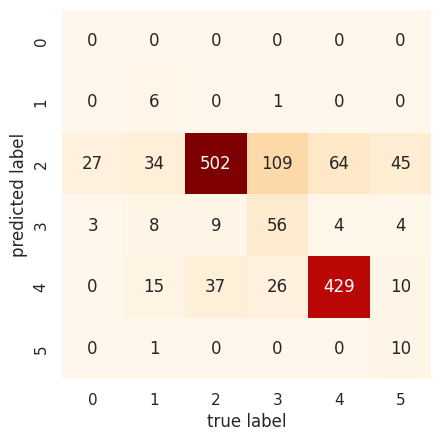

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.86      0.09      0.17        64
           2       0.64      0.92      0.76       548
           3       0.67      0.29      0.41       192
           4       0.83      0.86      0.85       497
           5       0.91      0.14      0.25        69

    accuracy                           0.72      1400
   macro avg       0.65      0.38      0.40      1400
weighted avg       0.72      0.72      0.67      1400

BernoulliNB roc-auc: 0.9055625517248004  f1-score: 0.7096762621653618



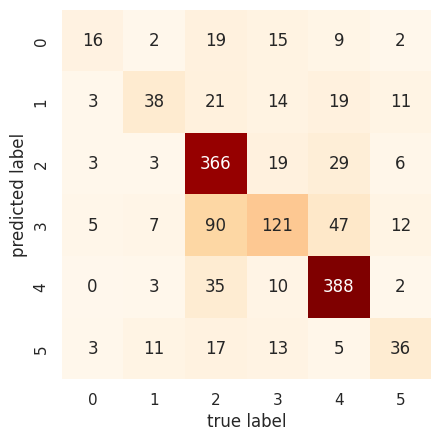

              precision    recall  f1-score   support

           0       0.25      0.53      0.34        30
           1       0.36      0.59      0.45        64
           2       0.86      0.67      0.75       548
           3       0.43      0.63      0.51       192
           4       0.89      0.78      0.83       497
           5       0.42      0.52      0.47        69

    accuracy                           0.69      1400
   macro avg       0.54      0.62      0.56      1400
weighted avg       0.75      0.69      0.71      1400

SVC roc-auc: 0.9493946154014505  f1-score: 0.7623955035517584



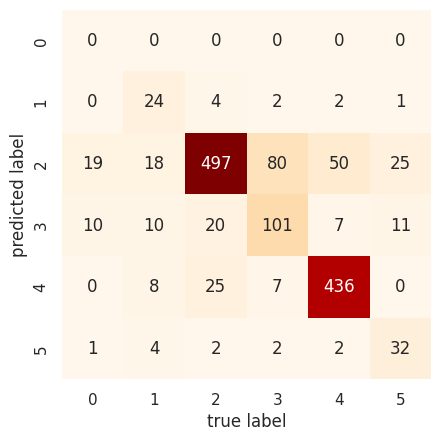

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.73      0.38      0.49        64
           2       0.72      0.91      0.80       548
           3       0.64      0.53      0.58       192
           4       0.92      0.88      0.90       497
           5       0.74      0.46      0.57        69

    accuracy                           0.78      1400
   macro avg       0.62      0.52      0.56      1400
weighted avg       0.76      0.78      0.76      1400

LR roc-auc: 0.9417349295263281  f1-score: 0.7730073654595354



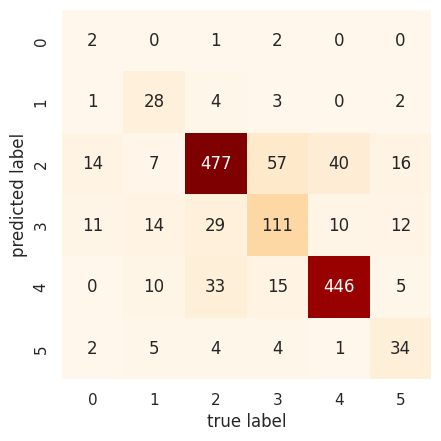

              precision    recall  f1-score   support

           0       0.40      0.07      0.11        30
           1       0.74      0.44      0.55        64
           2       0.78      0.87      0.82       548
           3       0.59      0.58      0.59       192
           4       0.88      0.90      0.89       497
           5       0.68      0.49      0.57        69

    accuracy                           0.78      1400
   macro avg       0.68      0.56      0.59      1400
weighted avg       0.77      0.78      0.77      1400

RF roc-auc: 0.8684491630480587  f1-score: 0.6717913372777895



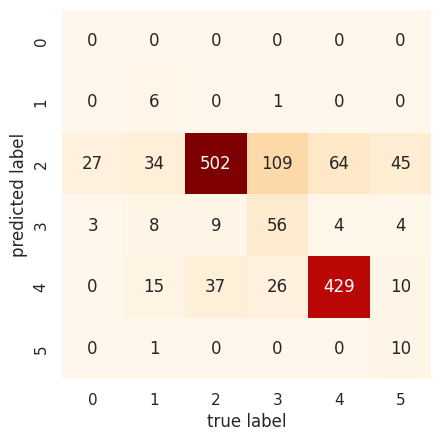

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.86      0.09      0.17        64
           2       0.64      0.92      0.76       548
           3       0.67      0.29      0.41       192
           4       0.83      0.86      0.85       497
           5       0.91      0.14      0.25        69

    accuracy                           0.72      1400
   macro avg       0.65      0.38      0.40      1400
weighted avg       0.72      0.72      0.67      1400

ETC roc-auc: 0.8744497288198555  f1-score: 0.650650372968078



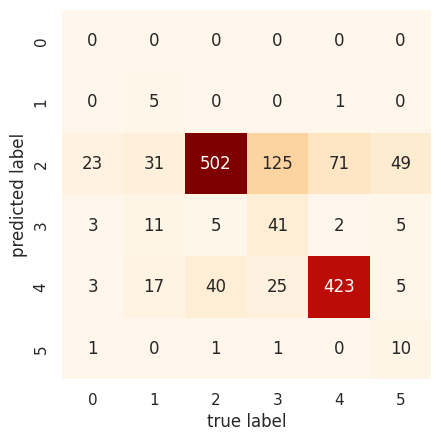

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.83      0.08      0.14        64
           2       0.63      0.92      0.74       548
           3       0.61      0.21      0.32       192
           4       0.82      0.85      0.84       497
           5       0.77      0.14      0.24        69

    accuracy                           0.70      1400
   macro avg       0.61      0.37      0.38      1400
weighted avg       0.70      0.70      0.65      1400

XGB roc-auc: 0.9344495102427349  f1-score: 0.7456089979010708



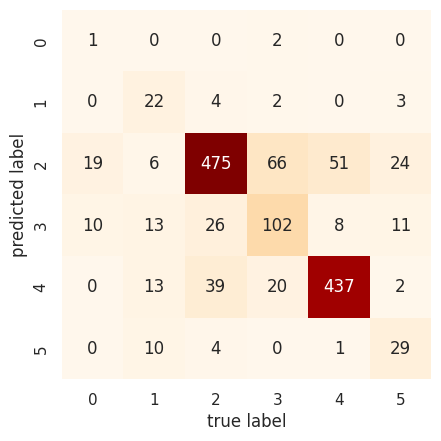

              precision    recall  f1-score   support

           0       0.33      0.03      0.06        30
           1       0.71      0.34      0.46        64
           2       0.74      0.87      0.80       548
           3       0.60      0.53      0.56       192
           4       0.86      0.88      0.87       497
           5       0.66      0.42      0.51        69

    accuracy                           0.76      1400
   macro avg       0.65      0.51      0.54      1400
weighted avg       0.75      0.76      0.75      1400

0:	learn: 1.3641060	total: 114ms	remaining: 1.03s
1:	learn: 1.2492321	total: 162ms	remaining: 648ms
2:	learn: 1.2006727	total: 207ms	remaining: 483ms
3:	learn: 1.1530666	total: 255ms	remaining: 383ms
4:	learn: 1.1067306	total: 303ms	remaining: 303ms
5:	learn: 1.0741328	total: 349ms	remaining: 233ms
6:	learn: 1.0396982	total: 395ms	remaining: 169ms
7:	learn: 1.0069026	total: 440ms	remaining: 110ms
8:	learn: 0.9761006	total: 487ms	remaining: 54.1ms
9:	lea

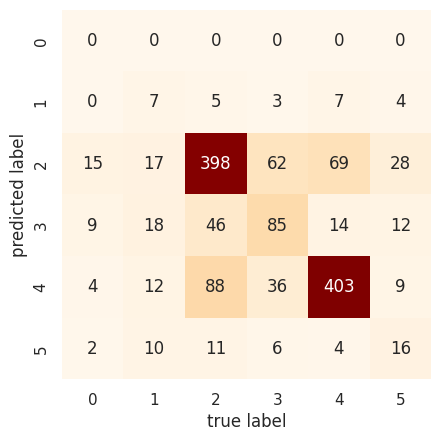

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.27      0.11      0.16        64
           2       0.68      0.73      0.70       548
           3       0.46      0.44      0.45       192
           4       0.73      0.81      0.77       497
           5       0.33      0.23      0.27        69

    accuracy                           0.65      1400
   macro avg       0.41      0.39      0.39      1400
weighted avg       0.62      0.65      0.63      1400



In [24]:
for name, model in models.items():
    model.fit(X_train_w2v, y_train)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_w2v), multi_class='ovr',)
    f1 = f1_score(y_test,  model.predict(X_test_w2v), average='weighted')
    prediction = model.predict(X_test_w2v)
    print(f'{name} roc-auc: {roc_auc}  f1-score: {f1}\n')
    confusion_mat(y_test, prediction)
    print(classification_report(y_test, prediction))

RandomForestClassifier roc-auc: 0.9186169793448317  f1-score: 0.734761384666257



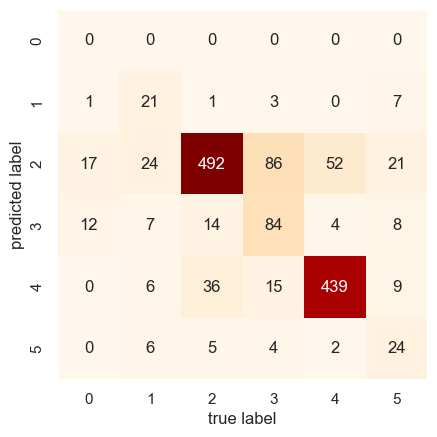

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.64      0.33      0.43        64
           2       0.71      0.90      0.79       548
           3       0.65      0.44      0.52       192
           4       0.87      0.88      0.88       497
           5       0.59      0.35      0.44        69

    accuracy                           0.76      1400
   macro avg       0.58      0.48      0.51      1400
weighted avg       0.73      0.76      0.73      1400

BernoulliNB roc-auc: 0.9157798353693088  f1-score: 0.7318512164338227



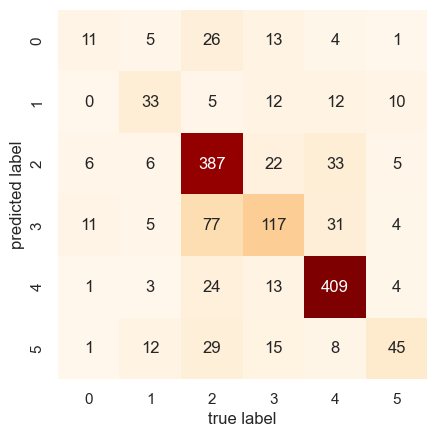

              precision    recall  f1-score   support

           0       0.18      0.37      0.24        30
           1       0.46      0.52      0.49        64
           2       0.84      0.71      0.77       548
           3       0.48      0.61      0.54       192
           4       0.90      0.82      0.86       497
           5       0.41      0.65      0.50        69

    accuracy                           0.72      1400
   macro avg       0.55      0.61      0.57      1400
weighted avg       0.76      0.72      0.73      1400

SVC roc-auc: 0.9585785449999354  f1-score: 0.8046807487473242



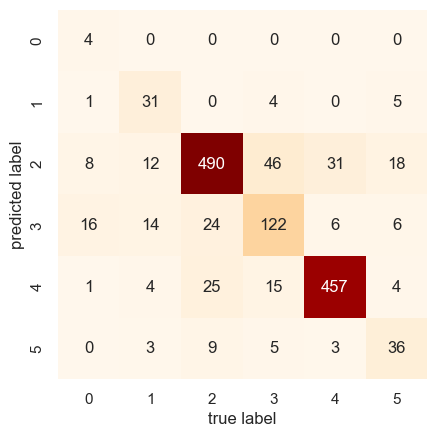

              precision    recall  f1-score   support

           0       1.00      0.13      0.24        30
           1       0.76      0.48      0.59        64
           2       0.81      0.89      0.85       548
           3       0.65      0.64      0.64       192
           4       0.90      0.92      0.91       497
           5       0.64      0.52      0.58        69

    accuracy                           0.81      1400
   macro avg       0.79      0.60      0.63      1400
weighted avg       0.81      0.81      0.80      1400

LR roc-auc: 0.9478733988134543  f1-score: 0.7870917196485678



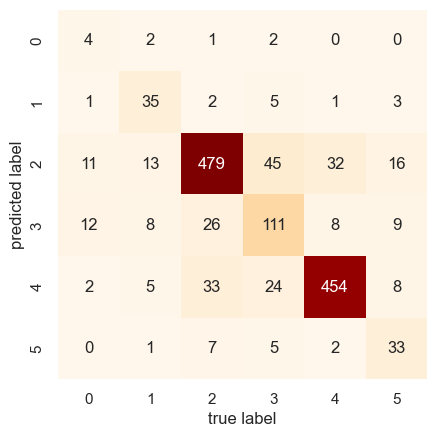

              precision    recall  f1-score   support

           0       0.44      0.13      0.21        30
           1       0.74      0.55      0.63        64
           2       0.80      0.87      0.84       548
           3       0.64      0.58      0.61       192
           4       0.86      0.91      0.89       497
           5       0.69      0.48      0.56        69

    accuracy                           0.80      1400
   macro avg       0.70      0.59      0.62      1400
weighted avg       0.79      0.80      0.79      1400

RF roc-auc: 0.9186169793448317  f1-score: 0.734761384666257



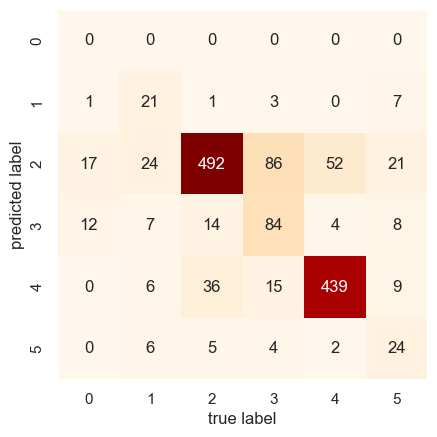

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.64      0.33      0.43        64
           2       0.71      0.90      0.79       548
           3       0.65      0.44      0.52       192
           4       0.87      0.88      0.88       497
           5       0.59      0.35      0.44        69

    accuracy                           0.76      1400
   macro avg       0.58      0.48      0.51      1400
weighted avg       0.73      0.76      0.73      1400

ETC roc-auc: 0.9244236793535227  f1-score: 0.7388294142513387



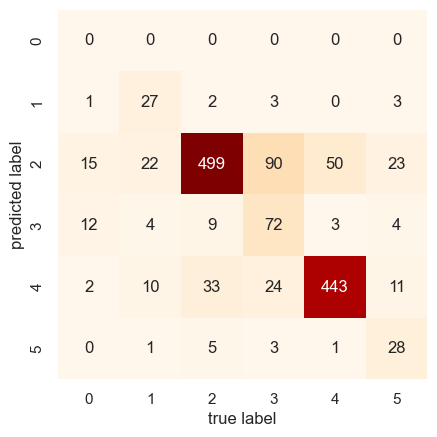

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.75      0.42      0.54        64
           2       0.71      0.91      0.80       548
           3       0.69      0.38      0.49       192
           4       0.85      0.89      0.87       497
           5       0.74      0.41      0.52        69

    accuracy                           0.76      1400
   macro avg       0.62      0.50      0.54      1400
weighted avg       0.75      0.76      0.74      1400

XGB roc-auc: 0.9469062461073344  f1-score: 0.7879113182012738



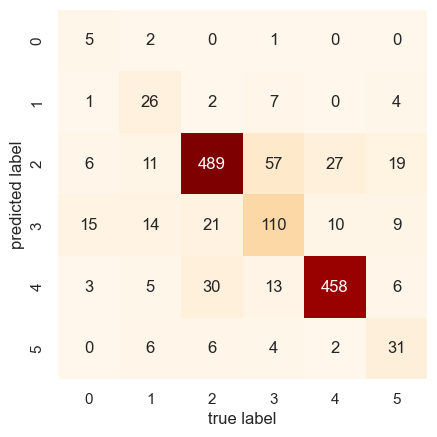

              precision    recall  f1-score   support

           0       0.62      0.17      0.26        30
           1       0.65      0.41      0.50        64
           2       0.80      0.89      0.85       548
           3       0.61      0.57      0.59       192
           4       0.89      0.92      0.91       497
           5       0.63      0.45      0.53        69

    accuracy                           0.80      1400
   macro avg       0.70      0.57      0.61      1400
weighted avg       0.79      0.80      0.79      1400

0:	learn: 1.2719694	total: 61.9ms	remaining: 557ms
1:	learn: 1.1850411	total: 63.9ms	remaining: 256ms
2:	learn: 1.0937564	total: 66.2ms	remaining: 155ms
3:	learn: 1.0051525	total: 68.7ms	remaining: 103ms
4:	learn: 0.9420686	total: 70.8ms	remaining: 70.8ms
5:	learn: 0.9167942	total: 73.2ms	remaining: 48.8ms
6:	learn: 0.8880687	total: 75.4ms	remaining: 32.3ms
7:	learn: 0.8584540	total: 77.7ms	remaining: 19.4ms
8:	learn: 0.8376822	total: 80.1ms	remaining: 

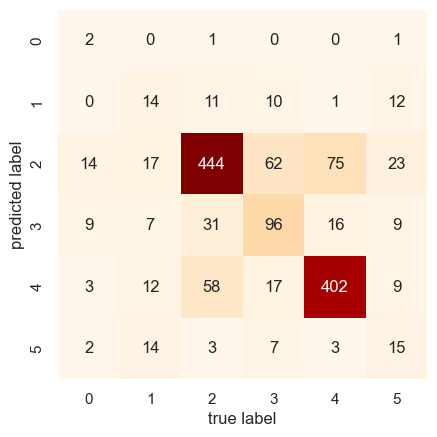

              precision    recall  f1-score   support

           0       0.50      0.07      0.12        30
           1       0.29      0.22      0.25        64
           2       0.70      0.81      0.75       548
           3       0.57      0.50      0.53       192
           4       0.80      0.81      0.81       497
           5       0.34      0.22      0.27        69

    accuracy                           0.69      1400
   macro avg       0.53      0.44      0.45      1400
weighted avg       0.68      0.69      0.68      1400



In [ ]:
for name, model in models.items():
    model.fit(X_train_glove_twitter, y_train)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_glove_twitter), multi_class='ovr',)
    f1 = f1_score(y_test,  model.predict(X_test_glove_twitter), average='weighted')
    prediction = model.predict(X_test_glove_twitter)
    print(f'{name} roc-auc: {roc_auc}  f1-score: {f1}\n')
    confusion_mat(y_test, prediction)
    print(classification_report(y_test, prediction))

RandomForestClassifier roc-auc: 0.9032865227351907  f1-score: 0.7060567333634301



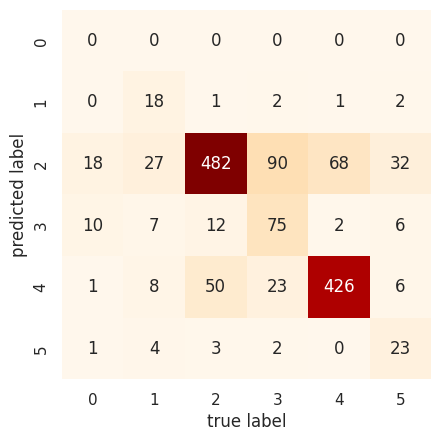

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.75      0.28      0.41        64
           2       0.67      0.88      0.76       548
           3       0.67      0.39      0.49       192
           4       0.83      0.86      0.84       497
           5       0.70      0.33      0.45        69

    accuracy                           0.73      1400
   macro avg       0.60      0.46      0.49      1400
weighted avg       0.72      0.73      0.71      1400

BernoulliNB roc-auc: 0.8875865714862222  f1-score: 0.6772754682011815



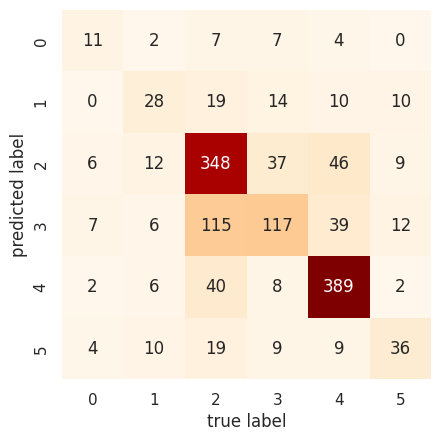

              precision    recall  f1-score   support

           0       0.35      0.37      0.36        30
           1       0.35      0.44      0.39        64
           2       0.76      0.64      0.69       548
           3       0.40      0.61      0.48       192
           4       0.87      0.78      0.82       497
           5       0.41      0.52      0.46        69

    accuracy                           0.66      1400
   macro avg       0.52      0.56      0.53      1400
weighted avg       0.70      0.66      0.68      1400

SVC roc-auc: 0.9437124245352274  f1-score: 0.7754367245747582



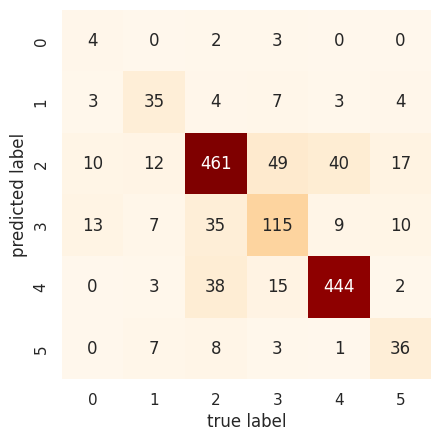

              precision    recall  f1-score   support

           0       0.44      0.13      0.21        30
           1       0.62      0.55      0.58        64
           2       0.78      0.84      0.81       548
           3       0.61      0.60      0.60       192
           4       0.88      0.89      0.89       497
           5       0.65      0.52      0.58        69

    accuracy                           0.78      1400
   macro avg       0.67      0.59      0.61      1400
weighted avg       0.77      0.78      0.78      1400

LR roc-auc: 0.9362719386238414  f1-score: 0.7732598554475368



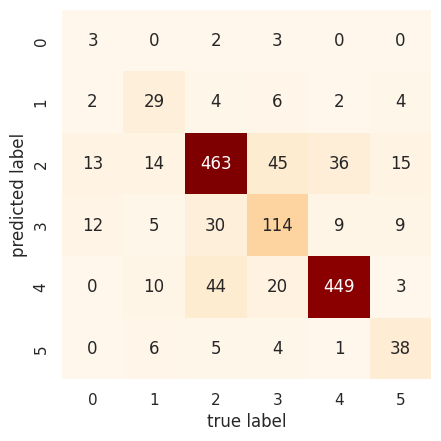

              precision    recall  f1-score   support

           0       0.38      0.10      0.16        30
           1       0.62      0.45      0.52        64
           2       0.79      0.84      0.82       548
           3       0.64      0.59      0.61       192
           4       0.85      0.90      0.88       497
           5       0.70      0.55      0.62        69

    accuracy                           0.78      1400
   macro avg       0.66      0.57      0.60      1400
weighted avg       0.77      0.78      0.77      1400

RF roc-auc: 0.9032865227351907  f1-score: 0.7060567333634301



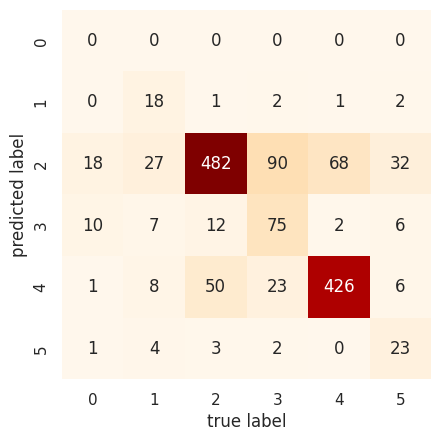

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.75      0.28      0.41        64
           2       0.67      0.88      0.76       548
           3       0.67      0.39      0.49       192
           4       0.83      0.86      0.84       497
           5       0.70      0.33      0.45        69

    accuracy                           0.73      1400
   macro avg       0.60      0.46      0.49      1400
weighted avg       0.72      0.73      0.71      1400

ETC roc-auc: 0.9130226101787061  f1-score: 0.6926776659002924



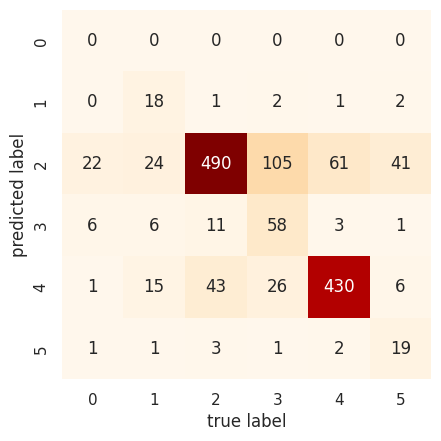

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.75      0.28      0.41        64
           2       0.66      0.89      0.76       548
           3       0.68      0.30      0.42       192
           4       0.83      0.87      0.84       497
           5       0.70      0.28      0.40        69

    accuracy                           0.73      1400
   macro avg       0.60      0.44      0.47      1400
weighted avg       0.71      0.72      0.69      1400

XGB roc-auc: 0.9311834840626005  f1-score: 0.757163993751603



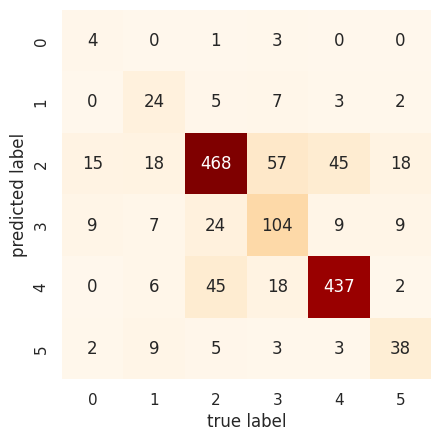

              precision    recall  f1-score   support

           0       0.50      0.13      0.21        30
           1       0.59      0.38      0.46        64
           2       0.75      0.85      0.80       548
           3       0.64      0.54      0.59       192
           4       0.86      0.88      0.87       497
           5       0.63      0.55      0.59        69

    accuracy                           0.77      1400
   macro avg       0.66      0.56      0.59      1400
weighted avg       0.76      0.77      0.76      1400

0:	learn: 1.2989886	total: 21.3ms	remaining: 192ms
1:	learn: 1.2204594	total: 36.8ms	remaining: 147ms
2:	learn: 1.1317505	total: 53.5ms	remaining: 125ms
3:	learn: 1.0884246	total: 68.4ms	remaining: 103ms
4:	learn: 1.0488595	total: 84ms	remaining: 84ms
5:	learn: 1.0143428	total: 100ms	remaining: 66.7ms
6:	learn: 0.9886775	total: 115ms	remaining: 49.1ms
7:	learn: 0.9574416	total: 135ms	remaining: 33.7ms
8:	learn: 0.9214625	total: 151ms	remaining: 16.8ms
9

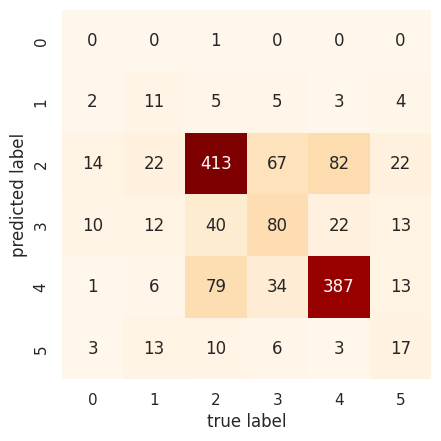

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.37      0.17      0.23        64
           2       0.67      0.75      0.71       548
           3       0.45      0.42      0.43       192
           4       0.74      0.78      0.76       497
           5       0.33      0.25      0.28        69

    accuracy                           0.65      1400
   macro avg       0.43      0.39      0.40      1400
weighted avg       0.62      0.65      0.63      1400



In [25]:
for name, model in models.items():
    model.fit(X_train_glove_wiki, y_train)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_glove_wiki), multi_class='ovr',)
    f1 = f1_score(y_test,  model.predict(X_test_glove_wiki), average='weighted')
    prediction = model.predict(X_test_glove_wiki)
    print(f'{name} roc-auc: {roc_auc}  f1-score: {f1}\n')
    confusion_mat(y_test, prediction)
    print(classification_report(y_test, prediction))

The best performance was shown by SVC algorithm with glove-twitter-model

## BERT + NN model

Additionaly we considered BERT model

In [ ]:
train_df, val_df = train_test_split(data[['texts', 'labels']], test_size=0.2, random_state=42)

In [ ]:
# Load the BERT tokenizer with a pre-trained 'bert-base-cased' model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenizes the input text examples
def tokenize_function(examples):
    return tokenizer(examples['texts'], padding="max_length", truncation=True)

train_encodings = tokenizer(train_df['texts'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['texts'].tolist(), truncation=True, padding=True)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Convert each encoding item to a torch tensor
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_df['labels'].tolist())
val_dataset = TextDataset(val_encodings, val_df['labels'].tolist())

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch.nn as nn
from transformers import BertModel

# A custom BERT-based classifier model
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        # A linear layer for classification, with input size equal to BERT's hidden size and output size equal to the number of classes
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

num_classes = 6

# Instantiate the BERT classifier model with a pre-trained 'bert-base-cased' model and the specified number of classes
model = BertClassifier(BertModel.from_pretrained("bert-base-cased"), num_classes=num_classes)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# A loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)  # Adam optimizer with a learning rate of 2e-5

num_epochs = 2

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        # Move batch data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute probabilities using softmax
            probs = nn.functional.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Average validation loss over all batches
    val_loss /= len(val_dataloader)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Convert lists to numpy arrays for ROC AUC calculation
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print(f'Epoch {epoch + 1}, Validation ROC AUC: {roc_auc}')


100%|█████████████████████████████████████████| 700/700 [08:12<00:00,  1.42it/s]


Epoch 1, Validation Loss: 0.5882066535417523
Epoch 1, Validation ROC AUC: 0.9349393443730625


100%|█████████████████████████████████████████| 700/700 [08:02<00:00,  1.45it/s]


Epoch 2, Validation Loss: 0.5821050795433776
Epoch 2, Validation ROC AUC: 0.9465795170806035


# LSTM

In [27]:
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data.texts, data.labels, test_size=0.2, random_state=42, stratify=y)

In [29]:
batch_size = 16

tokenizer = Tokenizer(num_words=len(X_train_glove_twitter))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=750)
X_val = pad_sequences(X_val, maxlen=750)

X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_test.tolist(), dtype=torch.long)

train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=False)

In [30]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(len(X_train_glove_twitter), len(X_train_glove_twitter[0]))
        self.embedding.weight = nn.Parameter(torch.tensor(X_train_glove_twitter, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(len(X_train_glove_twitter[0]), 64, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(256 , 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(128, 6)

    def forward(self, x):
        embed_layer = self.embedding(x)
        lstm_layer, _ = self.lstm(embed_layer)
        avg_pool = torch.mean(lstm_layer, 1)
        max_pool, _ = torch.max(lstm_layer, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        # conc = self.dropout(conc)
        # conc = self.relu(self.linear2(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [32]:
num_epochs = 5
model = BiLSTM()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device) 


for epoch in range(num_epochs):

    model.train()
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()        
    val_loss = 0
    val_preds = np.zeros((len(X_test), 6))
    for i, (x_batch, y_batch) in enumerate(val_dataloader):
        y_pred = model(x_batch).detach()
        val_loss += criterion(y_pred, y_batch).item() / len(val_dataloader)
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    print(sum(val_preds.argmax(axis=1)==y_test)/len(y_test))
    print('Epoch {}/{}  \t val_loss={:.4f} '.format(epoch + 1, num_epochs, val_loss))

0.5014285714285714
Epoch 1/5  	 val_loss=20.3639 
0.5678571428571428
Epoch 2/5  	 val_loss=17.9014 
0.6507142857142857
Epoch 3/5  	 val_loss=15.4888 
0.6528571428571428
Epoch 4/5  	 val_loss=14.9299 
0.6742857142857143
Epoch 5/5  	 val_loss=14.4215 


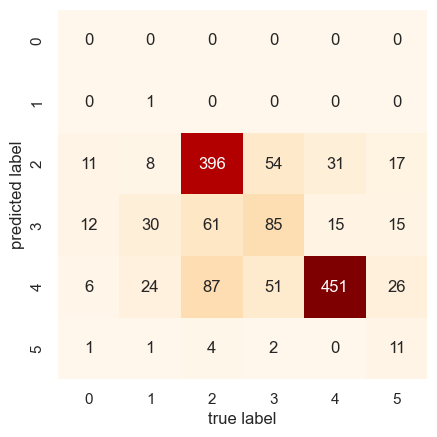

In [33]:
y_pred = val_preds.argmax(axis=1)
confusion_mat(y_test, y_pred)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       1.00      0.02      0.03        64
           2       0.77      0.72      0.74       548
           3       0.39      0.44      0.41       192
           4       0.70      0.91      0.79       497
           5       0.58      0.16      0.25        69

    accuracy                           0.67      1400
   macro avg       0.57      0.37      0.37      1400
weighted avg       0.68      0.67      0.64      1400



# Conclusion

The best result was achieved by using SVC model on glove-twitter embeddings with a score \
roc-auc: 0.9585785449999354  \
f1-score: 0.8046807487473242